In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as c
from random import choice
from astropy.table import Table
import spectral_cube
from astropy.io import fits
import pylab as plt
plt.style.use('dark_background')

In [2]:
%run ../coelho_model_paa/compile_coelho_models.py

[0.0, 4.506805018125192e-08, -2.028227509179075e-08, -1.2520778613237248e-08, -3.4587411622381465e-08, -2.5674961587622302e-08]
[0.0, -8.181100441306318e-08, 3.464095570850479e-08, -2.852320000032951e-08, 5.447691850674151e-09, -5.014998741504919e-09]
[0.0, -3.744660058364867e-09, 7.096778950807709e-08, -3.2123158726430166e-08, 3.28945117429085e-08, -1.5541774393394025e-08]
[0.0, -2.3451420777206215e-08, -5.9901023885480705e-09, 1.12070446339948e-08, -1.410091716783748e-09, -9.125758649775356e-09]
[0.0, 6.157984786082012e-08, 3.7135280633066447e-09, -7.612102584564027e-09, 4.653521563348967e-09, -2.5483456645915218e-08]


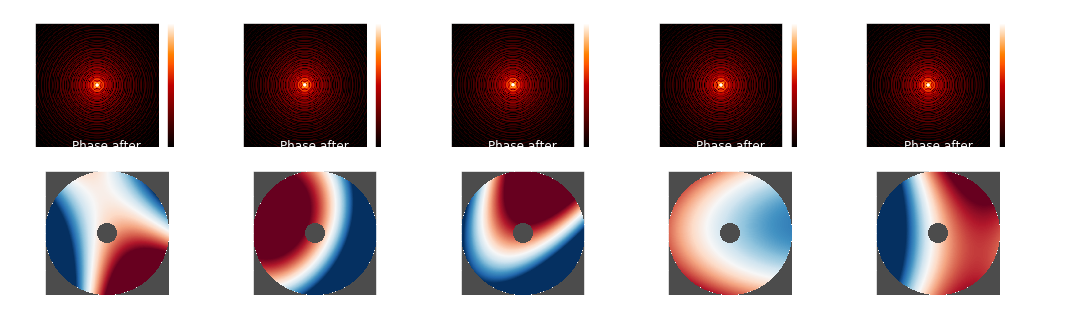

In [3]:
%run aperture_plane_model.py

In [4]:
fh = fits.open('./s_coelho14_sed/t03400_g+0.5_m13p04_sed.fits')

In [5]:
sp = lower_dimensional_structures.OneDSpectrum.from_hdu(fh)

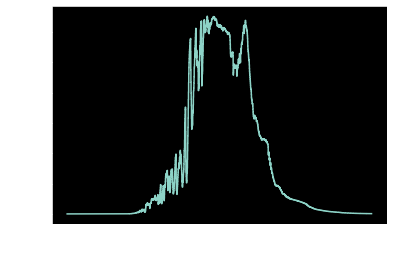

In [6]:
sp.quicklook()

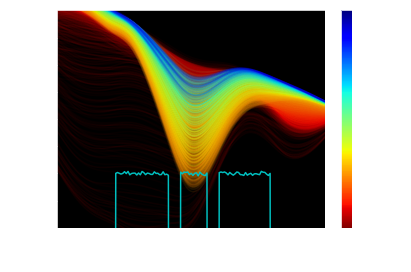

In [7]:
%run ../coelho_model_paa/coelho_specplot.py

In [8]:
models_table = table.Table.read('coelho14_model_paa.fits')

In [9]:
def value_keys(models_table):
    logg_values = []
    teff_values = []
    
    #creates a list of all of the possible logg and teff values
    #this makes matching quicker
    for value in models_table['logg']:
        if value not in logg_values:
            logg_values.append(value)
        
    for value in models_table['teff']:
        if value not in teff_values:
            teff_values.append(value)

    teff_dict = {"attribute": "effective temperature"}
    logg_dict = {"attribute": "surface gravity (log base 10)"}
    
    #this stores all of the indices for each teff and logg value in a dictionary
    #for easy access since those indices don't change from query to query
    for value in teff_values:
        indices = []
        for ii in range(len(models_table)):
            if models_table['teff'][ii] == value:
                indices.append(ii)
        teff_dict[f'value is {value}'] = indices
    
    for value in logg_values:
        indices = []
        for ii in range(len(models_table)):
            if models_table['logg'][ii] == value:
                indices.append(ii)
        logg_dict[f'value is {value}'] = indices

    return teff_dict, logg_dict, teff_values, logg_values

In [10]:
teff_dict, logg_dict, teff_values, logg_values = value_keys(models_table)

In [11]:
def correct_keys(jj, models_table, tbl):
    keys = []
    
    #this gives which teff and logg value the star is closest to
    init_min = np.argmin(np.abs(teff_values - tbl['teff'][jj]))
    teff_val = teff_values[init_min]
    init_min = np.argmin(np.abs(logg_values - tbl['logg'][jj]))
    logg_val = logg_values[init_min]
    
    #this gives the indices that correspond to that teff and logg value
    keys_teff = teff_dict[f'value is {teff_val}']
    keys_logg = logg_dict[f'value is {logg_val}']
    
    #this looks for any overlap between indices for teff and logg for a star
    for key in keys_teff:
        if key in keys_logg:
            keys.append(key)
    
    #if overlap can't be found, only the keys for teff are considered because that
    #seemed more important than prioriting logg
    #the choice function is to randomize which index is chosen 
    #since a lot of stars correspond to a particular teff logg combo
    if len(keys) == 0:
        index = choice(keys_teff)
    else:
        index = choice(keys)
    
    return index

In [12]:
def closest_model(name, VVV=False):
    """"
    This assumes that we value teff being correct over logg.
    Unfortunately, trying to find the best fit from existing data requires us to use a strict poset.
    So one has to be prioritized over the other.
    """
    data_stars = np.loadtxt('./TRILEGAL_data/' + name, unpack=True)
    
    logTe = []
    logg = []
    Av = []
    J = []
    H = []
    Ks = []
    
    zpt_J = 1594*u.Jy
    zpt_H = 1024*u.Jy
    zpt_Ks = 666.8*u.Jy
    
    index = 13
    
    #converting to the zeropoints for VVV
    if VVV:
        index += 2
        zpt_J -= 44.2*u.Jy
        zpt_H += 2.4*u.Jy
        zpt_Ks += 5.8*u.Jy
        
    zpts = Table({'J': [zpt_J],
                 'H': [zpt_H],
                 'Ks': [zpt_Ks],
                 'K': [zpt_Ks],
    })

    for ii in range(len(data_stars[0])):
        if data_stars[index, ii] >= 16:
            logTe.append(data_stars[5, ii])
            logg.append(data_stars[6, ii])
            Av.append(data_stars[8, ii])
            J.append(data_stars[index - 2, ii])
            H.append(data_stars[index - 1, ii])
            Ks.append(data_stars[index, ii])

    tbl = Table({'logTe': logTe,
                 'logg': logg,
                 'Av': Av,
                 'J': J,
                 'H': H,
                 'Ks': Ks,
                 })

    tbl.add_column(col=(10**tbl['logTe']), name='teff')
    
    data_rows = []
    #only keeping columns that seem relevant or interesting
    good_col = ['paa', 'paac_l', 'paac_h', 'J', 'H', 'K', 'fn']
    kept_col = ['Av', 'J', 'H', 'Ks']
    
    #faster way to make a table
    for jj in range(len(tbl)):
        #an index that prioritizes teff
        index = correct_keys(jj=jj, models_table=models_table, tbl=tbl)
        
        temp_dict = {}
        for hh in good_col:
            temp_dict[f'{hh} model'] = models_table[hh][index]
            
        for hh in kept_col:
            if hh is 'Av':
                temp_dict[f'{hh}'] = tbl[hh][jj]
                temp_dict['A_paa'] = np.round(0.15 * temp_dict['Av'], decimals=5)
            else:
                temp_dict[f'{hh} tril'] = tbl[hh][jj]
                temp_dict[f'{hh} flux tril'] = zpts[hh][0] * 10**(tbl[hh][jj] / -2.5)
        
        temp_dict['flux ratio'] = temp_dict['Ks flux tril'] / temp_dict['K model']
        temp_dict['f_paa'] = temp_dict['flux ratio'] * temp_dict['paa model']
        temp_dict['f_paac_l'] = temp_dict['flux ratio'] * temp_dict['paac_l model'] 
        temp_dict['f_paac_h'] = temp_dict['flux ratio'] * temp_dict['paac_h model'] 
        
        data_rows.append(temp_dict)
        
    result = Table(rows=data_rows)
    
    return result

I'm going to run this with some fainter stars. Limiting mag will be 32, l=0.1, b=2.5, pix=50, area=0.00012531558641975312deg2.

In [13]:
data_m_1 = closest_model('data_m_1.dat')
data_v_1 = closest_model('data_v_1.dat', VVV=True)
data_m_1

A_paa,Av,H flux tril,H model,H tril,J flux tril,J model,J tril,K model,Ks flux tril,Ks tril,f_paa,f_paac_h,f_paac_l,flux ratio,fn model,paa model,paac_h model,paac_l model
float64,float64,object,float64,float64,object,float64,float64,float64,object,float64,object,object,object,object,str43,float64,float64,float64
0.00525,0.035,2.7358983445687774e-06 Jy,1.65571264953118e-06,21.433,2.667401045501872e-06 Jy,1.8248437108103e-06,21.941,7.413824950360138e-07,2.331286190690023e-06 Jy,21.141,2.7992135101928236e-06 Jy,5.884983176513553e-06 Jy,8.482406799397209e-06 Jy,3.144512051875162 Jy,s_coelho14_sed\t03000_g+1.0_m01p04_sed.fits,8.901901039061284e-07,1.8715091815291882e-06,2.69752720277822e-06
0.0054,0.036,1.1321395353996362e-06 Jy,1.9192890509455965e-06,22.391,1.1253518184825072e-06 Jy,2.10803797091582e-06,22.878,8.669670791846922e-07,1.0195196276133657e-06 Jy,22.039,1.073456714245212e-06 Jy,2.3069857952910955e-06 Jy,3.2293677979667533e-06 Jy,1.1759611778709476 Jy,s_coelho14_sed\t03000_g+0.0_m05p04_sed.fits,9.128334629113202e-07,1.9617873775968044e-06,2.7461517086928452e-06
0.0051,0.034,1.8875564846138967e-07 Jy,2.101742834606175e-06,24.336,8.27348182254148e-08 Jy,2.413178619056456e-06,25.712,9.470220247468258e-07,2.8105776679399264e-07 Jy,23.438,2.621407164303613e-07 Jy,5.732804684781238e-07 Jy,7.821964246748738e-07 Jy,0.2967806021925729 Jy,s_coelho14_sed\t03000_g+0.0_m03p04_sed.fits,8.832811662679532e-07,1.9316642133711205e-06,2.6356049515908983e-06
0.0057,0.038,7.978108836998076e-07 Jy,2.7638752872162595e-06,22.771,7.721262493452575e-07 Jy,3.077037850670603e-06,23.287,1.2351078448687936e-06,6.619048924216038e-07 Jy,22.508,7.167748907256701e-07 Jy,1.5340096366147548e-06 Jy,2.159887085578215e-06 Jy,0.5359085809157973 Jy,s_coelho14_sed\t03000_g+0.5_m03p04_sed.fits,1.3374947075876188e-06,2.8624464903945634e-06,4.030327489601402e-06
0.0054,0.036,3.381426537134869e-07 Jy,1.150611344217374e-06,23.703,2.72701996223333e-07 Jy,1.222005789811277e-06,24.417,5.667715315608758e-07,3.5155687159673777e-07 Jy,23.195,3.056115843003554e-07 Jy,6.675377582518915e-07 Jy,9.081952354747952e-07 Jy,0.6202796929982672 Jy,s_coelho14_sed\t03000_g-0.5_p02p04_sed.fits,4.926996446121107e-07,1.0761883159920831e-06,1.4641705116684068e-06
0.00555,0.037,1.6199438321675866e-06 Jy,3.0860006982456336e-06,22.002,1.5477054684069449e-06 Jy,3.105586727069261e-06,22.532,1.4631651129728363e-06,1.3170297679901147e-06 Jy,21.761,1.3264807216131218e-06 Jy,2.8674086568486155e-06 Jy,3.97233025438583e-06 Jy,0.900123818093362 Jy,s_coelho14_sed\t03200_g+0.0_p02p04_sed.fits,1.473664728062487e-06,3.1855713616403876e-06,4.413093148451511e-06
0.0054,0.036,5.237209616346162e-06 Jy,1.610855881904323e-06,20.728,5.040670590308397e-06 Jy,1.7108081057357875e-06,21.25,7.934801441852261e-07,4.277554889981099e-06 Jy,20.482,3.7185173508950607e-06 Jy,8.122240333657287e-06 Jy,1.1050431052358913e-05 Jy,5.390878299007023 Jy,s_coelho14_sed\t03200_g-0.5_p02p04_sed.fits,6.89779502456955e-07,1.5066636423889164e-06,2.0498387163357695e-06
0.0051,0.034,6.581122225326279e-06 Jy,2.0601817536094537e-06,20.48,6.121929402669421e-06 Jy,3.11595617554325e-06,21.039,9.192201581720876e-07,5.214294919717165e-06 Jy,20.267,7.455681468213005e-06 Jy,1.4960778230851016e-05 Jy,2.26573849598454e-05 Jy,5.6725202046113035 Jy,s_coelho14_sed\t03600_g+5.0_p00p00_sed.fits,1.3143507998705997e-06,2.6374129471921676e-06,3.994236096581333e-06
0.00555,0.037,0.00016199438321675834 Jy,5.613481758074143e-06,17.002,0.00019502411556909433 Jy,1.1654193006539325e-05,17.281,2.1557805333933856e-06,0.00010944491571969882 Jy,16.962,0.00017079549384048804 Jy,0.0003503311109818197 Jy,0.000539225799337994 Jy,50.768115781908016 Jy,s_coelho14_sed\t06000_g+4.5_p00p04_sed.fits,3.364227551288275e-06,6.900612827286875e-06,1.0621347494053643e-05


In [14]:
data_v_1

A_paa,Av,H flux tril,H model,H tril,J flux tril,J model,J tril,K model,Ks flux tril,Ks tril,f_paa,f_paac_h,f_paac_l,flux ratio,fn model,paa model,paac_h model,paac_l model
float64,float64,object,float64,float64,object,float64,float64,float64,object,float64,object,object,object,object,str43,float64,float64,float64
0.00555,0.037,8.584532385618436e-07 Jy,1.9584730087041824e-06,22.694,8.627315025743383e-07 Jy,2.3392739897736466e-06,23.136,8.533255050380389e-07,7.320771691408605e-07 Jy,22.408,7.25539081335136e-07 Jy,1.5720709985530702e-06 Jy,2.175101384791912e-06 Jy,0.8579108028749551 Jy,s_coelho14_sed\t03000_g+0.0_m10p04_sed.fits,8.457045638121974e-07,1.8324410804536837e-06,2.535346772068732e-06
0.0057,0.038,5.017838084129498e-07 Jy,1.6964035930292533e-06,23.277,4.663109959545552e-07 Jy,2.8558559846075556e-06,23.804,7.391607198352458e-07,4.0008923203895817e-07 Jy,23.064,5.035857610930766e-07 Jy,1.0367231037095305e-06 Jy,1.5268422269205895e-06 Jy,0.5412750181423811 Jy,s_coelho14_sed\t03400_g+5.0_m01p04_sed.fits,9.30369487255016e-07,1.9153352158529195e-06,2.820825228846895e-06
0.00495,0.033,2.8087730106631538e-06 Jy,1.4107201593097933e-06,21.407,2.738266142343821e-06 Jy,2.004769733093252e-06,21.882,6.280039533036069e-07,2.3107707575745544e-06 Jy,21.16,2.11159348316165e-06 Jy,4.582513219092152e-06 Jy,6.296801603150588e-06 Jy,3.6795481070123426 Jy,s_coelho14_sed\t03000_g+0.0_m13p04_sed.fits,5.738730468389462e-07,1.24540108888887e-06,1.7112975343766762e-06
0.00555,0.037,4.644261266949347e-07 Jy,2.232033630424909e-06,23.361,4.5151861151392544e-07 Jy,2.2781759263401267e-06,23.839,1.0640190017297224e-06,3.8102797527707753e-07 Jy,23.117,4.0520917493032565e-07 Jy,8.681660292546907e-07 Jy,1.2156541685924937e-06 Jy,0.3581026040490437 Jy,s_coelho14_sed\t03000_g+0.0_p02p00_sed.fits,1.1315448990000377e-06,2.4243499473011137e-06,3.3947090997026222e-06
0.00525,0.035,2.0764268849953826e-06 Jy,1.3307571149825748e-06,21.735,1.94211819292421e-06 Jy,2.4404324131422775e-06,22.255,5.912872339532149e-07,1.6832819364867188e-06 Jy,21.504,1.968654452646625e-06 Jy,4.078714541475842e-06 Jy,5.942898352860881e-06 Jy,2.8468091983530073 Jy,s_coelho14_sed\t03200_g+5.0_p02p04_sed.fits,6.91530171317969e-07,1.4327319666648334e-06,2.087564686913013e-06
0.0057,0.038,9.456199876790083e-07 Jy,1.603179200884791e-06,22.589,8.869020455535623e-07 Jy,2.7236017180133274e-06,23.106,7.048428911776357e-07,7.553650089561323e-07 Jy,22.374,9.435794447669821e-07 Jy,1.939590818807597e-06 Jy,2.859042873548215e-06 Jy,1.0716785519310343 Jy,s_coelho14_sed\t03400_g+5.0_m03p04_sed.fits,8.804687217699438e-07,1.8098624959067162e-06,2.6678175730927596e-06
0.0054,0.036,0.00022746608001650574 Jy,5.542986522267484e-06,16.636,0.00026054074854443924 Jy,1.1335135325081413e-05,16.936,2.131475025079318e-06,0.00015337580776274797 Jy,16.605,0.00023968763067976995 Jy,0.0004913000137722663 Jy,0.000756908997524123 Jy,71.95759085051462 Jy,s_coelho14_sed\t06000_g+4.5_m05p00_sed.fits,3.330956857320297e-06,6.827632887166798e-06,1.051882071895004e-05
0.0054,0.036,6.224674458220043e-07 Jy,2.227849733794094e-06,23.043,6.102048519655782e-07 Jy,2.312578411110012e-06,23.512,9.830365945059011e-07,5.357434412625685e-07 Jy,22.747,5.102200180991564e-07 Jy,1.1171887576651827e-06 Jy,1.523681067540227e-06 Jy,0.5449882987640421 Jy,s_coelho14_sed\t03000_g-0.5_m05p04_sed.fits,9.362036198873713e-07,2.0499316410991058e-06,2.7958051044320117e-06
0.00555,0.037,1.3394195802632626e-06 Jy,1.6964035930292533e-06,22.211,1.2447314321461329e-06 Jy,2.8558559846075556e-06,22.738,7.391607198352458e-07,1.0689486988429482e-06 Jy,21.997,1.3454682130106992e-06 Jy,2.769891624233505e-06 Jy,4.0793800010251425e-06 Jy,1.44616545516814 Jy,s_coelho14_sed\t03400_g+5.0_m01p04_sed.fits,9.30369487255016e-07,1.9153352158529195e-06,2.820825228846895e-06


In [15]:
def flux_per_pix(pixels, name, VVV=False):
    new_data = closest_model(name, VVV=VVV)
    dimmed_flux = new_data['f_paa'] * 10**(new_data['A_paa']/-2.5)
    total_flux = dimmed_flux.sum()
    fpp = total_flux / (pixels**2)
    return fpp

In [16]:
data_m_1 = flux_per_pix(50, 'data_m_1.dat')
data_v_1 = flux_per_pix(50, 'data_v_1.dat', VVV=True)

In [17]:
data_m_1, data_v_1

(<Quantity 0.00012657 Jy>, <Quantity 0.00012372 Jy>)

In [18]:
data_m_2 = flux_per_pix(50, 'data_30_01_m.dat')
data_v_2 = flux_per_pix(50, 'data_30_01_v.dat', VVV=True)

In [19]:
data_m_2, data_v_2

(<Quantity 1.92750046e-07 Jy>, <Quantity 7.2394097e-08 Jy>)

In [20]:
data_m_3 = flux_per_pix(50, 'data_45_01_m.dat')
data_v_3 = flux_per_pix(50, 'data_45_01_v.dat', VVV=True)

In [21]:
data_m_3, data_v_3

(<Quantity 5.81948886e-09 Jy>, <Quantity 2.1571633e-08 Jy>)

In [22]:
data_m_4 = flux_per_pix(50, 'data_5_1_m.dat')
data_v_4 = flux_per_pix(50, 'data_5_1_v.dat', VVV=True)

In [23]:
data_m_4, data_v_4

(<Quantity 2.95885611e-05 Jy>, <Quantity 2.88474375e-05 Jy>)

In [24]:
data_m_5 = flux_per_pix(50, 'data_3_0_m.dat')
data_v_5 = flux_per_pix(50, 'data_3_0_v.dat', VVV=True)

In [25]:
data_m_5, data_v_5

(<Quantity 9.40850155e-05 Jy>, <Quantity 9.20047178e-05 Jy>)

Limiting mag will be 32, l=1.5, b=0.5, pix=50, area=0.00012531558641975312deg2.

In [26]:
data_m_6 = flux_per_pix(50, 'data_1p5_0p5_m.dat')
data_v_6 = flux_per_pix(50, 'data_1p5_0p5_v.dat', VVV=True)

In [27]:
data_m_6, data_v_6

(<Quantity 0.00045777 Jy>, <Quantity 0.00046241 Jy>)

Limiting mag will be 32, l=0.5, b=0.5, pix=50, area=0.00012531558641975312deg2.

In [28]:
data_m_7 = flux_per_pix(50, 'data_0p1_0p5_m.dat')
data_v_7 = flux_per_pix(50, 'data_0p1_0p5_v.dat', VVV=True)

In [29]:
data_m_7, data_v_7

(<Quantity 0.00060093 Jy>, <Quantity 0.00060036 Jy>)

# Frequency of star magnitude

The following calculations are done assuming that the pixel scale is 1" per pixel. The file naming convention is as follows: 

freq: indicates that this data was taken for this section

first number: l, the p designates a . and the n designates a negative sign

second number: b, the p designates a . and the n designates a negative sign

third number: pixel scale

m/v: whether the data use 2MASS filters (m) or VVV filters (v)

In [30]:
def star_frequency(name, pixel, VVV=False):
    """
    Because TRILEGAL does not provide x and y coordinates, this is my next attempt to find the frequency.
    If the number are useless, I'll try something else, but this seems like a decent preliminary. 
    """

    data_stars = np.loadtxt('./TRILEGAL_data/' + name, unpack=True)
    
    index = 13
    if VVV:
        index += 2
        
    star_count = 0
        
    for ii in range(len(data_stars[0])):
        if data_stars[index, ii] >= 16 and data_stars[index, ii] < 17:
            star_count += 1
            
    star_freq = star_count / (pixel**2)
    
    return star_count, star_freq

In [31]:
freq_m_1 = star_frequency('freq_0p1_2p5_1_m.dat', 50)
freq_v_1 = star_frequency('freq_0p1_2p5_1_v.dat', 50, VVV=True)
freq_m_1, freq_v_1

((450, 0.18), (405, 0.162))

In [32]:
freq_m_2 = star_frequency('freq_0p1_n2p5_1_m.dat', 50)
freq_v_2 = star_frequency('freq_0p1_n2p5_1_v.dat', 50, VVV=True)
freq_m_2, freq_v_2

((495, 0.198), (494, 0.1976))

In [33]:
freq_m_3 = star_frequency('freq_1_n40_1_m.dat', 50)
freq_v_3 = star_frequency('freq_1_n40_1_v.dat', 50, VVV=True)
freq_m_3, freq_v_3

((1, 0.0004), (0, 0.0))

In [34]:
freq_m_4 = star_frequency('freq_0_0_1_m.dat', 50)
freq_v_4 = star_frequency('freq_0_0_1_v.dat', 50, VVV=True)
freq_m_4, freq_v_4

((3923, 1.5692), (3835, 1.534))

In [35]:
freq_m_5 = star_frequency('freq_0p1_0p1_1_m.dat', 50)
freq_v_5 = star_frequency('freq_0p1_0p1_1_v.dat', 50, VVV=True)
freq_m_5, freq_v_5

((3223, 1.2892), (3276, 1.3104))

Clearly, the ratio of stars to pixels is much higher the closer you get to the Galactic center. While - due to the lack of provided coordinates - we cannot extrapolate how close together any stars are, an upper bound for what percentage of the pixels contain stars is provided for the first 3 regions. The data from the second 2 regions are inconclusive. 